In [1]:
import pandas as pd
import numpy as np
import numpy_financial as npf
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
mu_stock = .1081
sigma_stock = .2267

mu_home = .0572
sigma_home = .1042

In [3]:
def simulate_returns(mu_stock=.1081,
                     sigma_stock=.2267,
                     mu_home=.0572,
                     sigma_home=.1042,
                     condo_cost = .02,
                     years = 30,
                     seed=None):
    cov = 0.5 * sigma_stock * sigma_home
    cov_matrix = np.array([[sigma_stock**2, cov],
                [cov, sigma_home**2]])
    returns_df = pd.DataFrame(np.random
                            .default_rng(seed)
                            .multivariate_normal([mu_stock, mu_home],
                                                cov_matrix,
                                                years * 12),
                            columns=["Stock_Appreciation", "Home_Appreciation"])
    returns_df['Stock_Appreciation'] = returns_df['Stock_Appreciation'] * .6
    returns_df['Condo_Appreciation'] = returns_df['Home_Appreciation'] - condo_cost + np.random.normal(0, .005, len(returns_df))
    returns_df = (returns_df / 12)
    returns_df.index = pd.date_range(
        start=datetime.today().date(),
        periods=12*years,
        freq='MS',
        name="Date")
    return returns_df

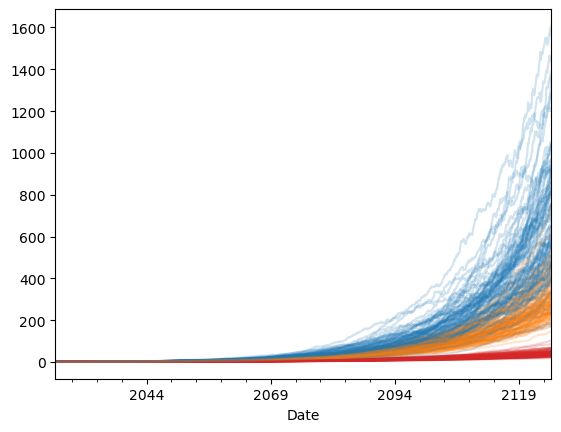

In [4]:
fig, ax = plt.subplots()
for i in range(100):
    returns_df = simulate_returns(years = 100)
    cum_returns = returns_df.add(1).cumprod()
    cum_returns['Home_Appreciation'].plot(alpha=.2, ax=ax, legend=False, color="tab:orange")
    cum_returns['Condo_Appreciation'].plot(alpha=.2, ax=ax, legend=False, color="tab:red")
    cum_returns['Stock_Appreciation'].plot(alpha=.2, ax=ax, legend=False, color="tab:blue")

In [5]:
def salt_deduction(property_tax):
    """Caps SALT deduction (property + state income tax) at $10,000"""
    return np.minimum(property_tax, 40000)

def itemized_vs_standard_deduction(itemized, standard_deduction=14600):
    """Chooses the better deduction (standard or itemized)"""
    return np.maximum(itemized, standard_deduction)

def apply_compounding(growth, start, deposits):
    growth = np.array(growth)
    deposits = np.array(deposits)
    balance = float(start)
    balances = []
    for i in range(len(growth)):
        balance = (balance + deposits[i]) * (1 + growth[i])
        balances.append(balance)
    return balances

def initiate_model(today, years = 30):
    df_own = pd.DataFrame()
    df_own["Period"] =  pd.Series(range(12*years)) + 1
    df_own["Date"] = pd.date_range(
        start=today,
        periods=12*years,
        freq='MS',
        name="Date")
    df_own = df_own.set_index('Date')
    return df_own

def mortgage_calc(df_own, interest_rate, principal):
     # Ensure "Period" column is an integer
    df_own = df_own.copy()
    df_own["Period"] = df_own["Period"].astype(int)

    # Loan term in months
    loan_term_months = 12 * 30
    
    # Compute principal and interest payments
    df_own["Principal_monthly"] = npf.ppmt(interest_rate / 12, df_own["Period"], loan_term_months, principal) * -1
    df_own["Interest_monthly"] = npf.ipmt(interest_rate / 12, df_own["Period"], loan_term_months, principal) * -1

    # Zero out values beyond the loan term
    df_own.loc[df_own["Period"] > loan_term_months, ["Principal_monthly", "Interest_monthly"]] = 0

    return df_own

today = datetime.today().date()

In [33]:
def owner_table(interest_rate=0.065,
                renovation=0,
                cost=1000000,
                hoa=0,
                returns_df=returns_df,
                mean_reno_return=.5,
                cg_tax=.15,
                closing_fees=0.032,
                selling_fees=.07,
                pct_down=.2,
                condo=False,
                start_date=None,
                years=30,
                upgrade=None,
                avg_income_growth = .02,
                upgrade_cost_today=1500000,
                max_monthly=8300,
                max_down=300000,
                pay_back_parents_years = 10,
                verbose=False):
    
    if not start_date:
        today = datetime.today().date()
    else:
        today = start_date
    df_own = initiate_model(today, years=years)
    is_year = df_own.index.month == 1
    df_own = df_own.merge(returns_df, left_index=True, right_index=True, how="left")
    
    down_payment = cost * pct_down
    principal = cost - down_payment
    buying_fees = cost*closing_fees
    reno_return = np.random.lognormal(np.log(mean_reno_return), 0.2)
    post_reno_value = (cost + renovation * reno_return)
    year = is_year.cumsum()

    df_own["Purchase_cost"] = buying_fees + down_payment + renovation
    df_own = mortgage_calc(df_own, interest_rate, principal)
    df_own['HOA_monthly'] = hoa
    df_own["PropTax_monthly"] = np.round((cost * 1.02**((year)) * 0.0144) / 12, 2)
    df_own['Max_Monthly'] = np.round((max_monthly * 1.02**((year))), 2)
    annual_proptax = df_own.resample("YE")['PropTax_monthly'].sum().rename("PropTax_annual").reindex(df_own.index, method="bfill")
    df_own = df_own.merge(
        annual_proptax, left_index=True, right_index=True, how="left"
        )
    annual_interest = df_own.resample("YE")['Interest_monthly'].sum().rename("Interest_annual").reindex(df_own.index, method="bfill")
    df_own = df_own.merge(
        annual_interest, left_index=True, right_index=True, how="left"
        )
    df_own['Total_deduction'] = itemized_vs_standard_deduction(
        df_own['Interest_annual'] + df_own["PropTax_annual"].apply(salt_deduction)
        )
    df_own['Tax_Savings_annual'] = (df_own['Total_deduction'] * 0.24 + df_own['Total_deduction'] * 0.093)
    df_own['Tax_Savings_monthly'] = df_own['Tax_Savings_annual'] / 12
    df_own['Pre_tax_monthly'] = df_own[["Principal_monthly", "Interest_monthly", "PropTax_monthly", "HOA_monthly"]].sum(axis=1)
    df_own['Post_tax_monthly'] = df_own['Pre_tax_monthly'] - df_own['Tax_Savings_monthly']
    df_own['Unproductive_cost'] = df_own['Post_tax_monthly'] - df_own["Principal_monthly"]
    df_own["Balance_Remaining"] = principal - df_own["Principal_monthly"].cumsum()
    if condo:
        df_own["Home_Value"] = apply_compounding(growth=df_own['Condo_Appreciation'],
                                            start=post_reno_value,
                                            deposits=np.zeros_like(df_own['Condo_Appreciation'])
                                            ) 
    else:
        df_own["Home_Value"] = apply_compounding(growth=df_own['Home_Appreciation'],
                                                start=post_reno_value,
                                                deposits=np.zeros_like(df_own['Home_Appreciation'])
                                                ) 
        df_own = df_own.drop(columns=['Condo_Appreciation', 'HOA_monthly'])
    
    df_own["Sale_fee"] = df_own["Home_Value"] * selling_fees
    df_own['Capital_gain'] = (df_own["Home_Value"] - cost)
    df_own["Sale_tax"]  = np.maximum(0, (df_own['Capital_gain'] - 500000)) * cg_tax
    df_own['Profit'] = df_own['Capital_gain'] - df_own["Sale_tax"] - df_own["Sale_fee"] - buying_fees + down_payment + df_own["Principal_monthly"].cumsum()
    # Opp Costs
    added_costs = np.zeros_like(df_own['Post_tax_monthly'].values)
    if df_own["Purchase_cost"].iloc[0] <= max_down:
        savings_1 = (max_down - df_own["Purchase_cost"].iloc[0])
    else:
        savings_1 = 0
        additional_monthly = (df_own["Purchase_cost"].iloc[0] - max_down) / pay_back_parents_years / 12
        added_costs[:pay_back_parents_years*12] = additional_monthly
        if verbose:
            print("\tTotal Reno:", renovation)
            print("\tReno excess monthly:", additional_monthly)
        df_own['Pre_tax_monthly'] = df_own['Pre_tax_monthly'] + added_costs
        df_own['Post_tax_monthly'] = df_own['Post_tax_monthly'] + added_costs

    diff_0 = df_own['Max_Monthly'] - df_own['Post_tax_monthly'] - added_costs
    diff_0[diff_0 < 0] = 0
    df_own['Stock_savings'] = (
        pd.Series(apply_compounding(df_own['Stock_Appreciation'],
                                    0,
                                    diff_0)).multiply(.85).values +
                                    pd.Series(apply_compounding(
                                        df_own['Stock_Appreciation'],
                                        savings_1,
                                        np.zeros_like(df_own['Stock_Appreciation']))).multiply(.85).values
    )
    df_own['Full_profit'] = df_own['Stock_savings'] + df_own['Profit']
    if upgrade is not None:
        house_2_max_dp = df_own['Full_profit'][upgrade]
        years_elapsed = pd.to_datetime(upgrade).year - today.year - 1
        house_2_max_monthly = max_monthly * (1 + avg_income_growth)**int(years_elapsed)
        df_own['_upgrade'] = apply_compounding(growth=df_own['Home_Appreciation'],
                                         start=upgrade_cost_today,
                                         deposits=np.zeros_like(
                                             df_own['Home_Appreciation'])
                                         )
        house_2_cost = df_own.loc[upgrade, '_upgrade']
        new_house = pd.concat([
            df_own[:upgrade].iloc[:-1],
            owner_table(start_date=upgrade,
                        cost=house_2_cost,
                        years=years,
                        max_down=house_2_max_dp,
                        max_monthly=house_2_max_monthly)
            ]).iloc[:years*12]
        if verbose:
            print("Upgrade house price:", house_2_cost)
            print("\tmonthly postax Year 1:", new_house.loc[upgrade, 'Post_tax_monthly'])
            print("\tmonthly interest+tax Year 1:", new_house.loc[upgrade, 'Unproductive_cost'])
            print("\tmonthly pretax", new_house.loc[upgrade, 'Pre_tax_monthly'])
        return new_house
    else:
        return df_own

In [35]:
owner_table(years=30)

,Period,Stock_Appreciation,Home_Appreciation,Purchase_cost,Principal_monthly,Interest_monthly,PropTax_monthly,Max_Monthly,PropTax_annual,Interest_annual,Total_deduction,Tax_Savings_annual,Tax_Savings_monthly,Pre_tax_monthly,Post_tax_monthly,Unproductive_cost,Balance_Remaining,Home_Value,Sale_fee,Capital_gain,Sale_tax,Profit,Stock_savings,Full_profit
Date,,,,,,,,,,,,,,,,,,,,,,,,
2025-08-01,1,0.022944,0.010796,232000.0,723.210855,4333.333333,1200.00,8300.0,6000.00,21627.279978,27627.279978,9199.884233,766.657019,6256.544188,5489.887169,4766.676314,7.992768e+05,1.010796e+06,70755.692844,1.079561e+04,0.000000,1.087631e+05,6.156958e+04,1.703327e+05
2025-09-01,2,0.012788,0.004507,232000.0,727.128247,4329.415941,1200.00,8300.0,6000.00,21627.279978,27627.279978,9199.884233,766.657019,6256.544188,5489.887169,4762.758922,7.985497e+05,1.015351e+06,71074.556308,1.535080e+04,0.000000,1.137266e+05,6.477608e+04,1.785027e+05
2025-10-01,3,-0.005750,-0.014312,232000.0,731.066858,4325.477330,1200.00,8300.0,6000.00,21627.279978,27627.279978,9199.884233,766.657019,6256.544188,5489.887169,4758.820310,7.978186e+05,1.000819e+06,70057.357518,8.193931e+02,0.000000,1.009434e+05,6.677849e+04,1.677219e+05
2025-11-01,4,0.008292,0.001794,232000.0,735.026804,4321.517384,1200.00,8300.0,6000.00,21627.279978,27627.279978,9199.884233,766.657019,6256.544188,5489.887169,4754.860365,7.970836e+05,1.002615e+06,70183.052632,2.615038e+03,0.000000,1.033484e+05,6.974065e+04,1.730891e+05
2025-12-01,5,-0.000480,-0.005499,232000.0,739.008199,4317.535989,1200.00,8300.0,6000.00,21627.279978,27627.279978,9199.884233,766.657019,6256.544188,5489.887169,4750.878970,7.963446e+05,9.971017e+05,69797.119378,-2.898295e+03,0.000000,9.896003e+04,7.209465e+04,1.710547e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055-03-01,356,0.003089,0.004489,232000.0,4921.793697,134.750490,2173.63,15034.3,15215.41,754.613698,15970.023698,5318.017891,443.168158,7230.174188,6787.006030,1865.212333,1.995522e+04,4.403535e+06,308247.481423,3.403535e+06,435530.317335,3.607802e+06,5.462392e+06,9.070194e+06
2055-04-01,357,-0.000524,0.000889,232000.0,4948.453413,108.090775,2173.63,15034.3,15215.41,754.613698,15970.023698,5318.017891,443.168158,7230.174188,6787.006030,1838.552617,1.500677e+04,4.407451e+06,308521.539021,3.407451e+06,436117.583616,3.615805e+06,5.466536e+06,9.082341e+06
2055-05-01,358,-0.012002,-0.010573,232000.0,4975.257536,81.286652,2173.63,15034.3,15215.41,754.613698,15970.023698,5318.017891,443.168158,7230.174188,6787.006030,1811.748494,1.003151e+04,4.360850e+06,305259.534090,3.360850e+06,429127.573050,3.584432e+06,5.407855e+06,8.992287e+06


<AxesSubplot: xlabel='Date'>

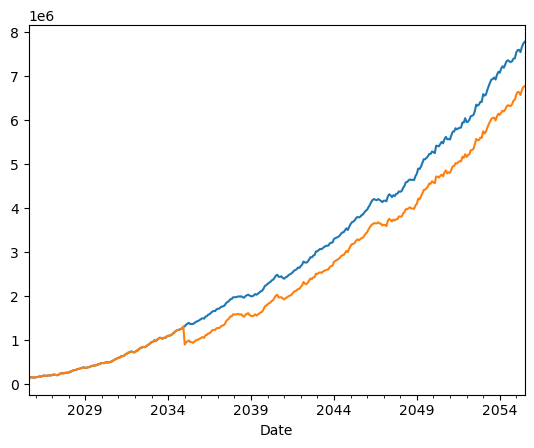

In [11]:
owner_table(years=30)['Full_profit'].plot(label='')
owner_table(years=30, upgrade='2035-01-01')['Full_profit'].plot()

<AxesSubplot: xlabel='Date'>

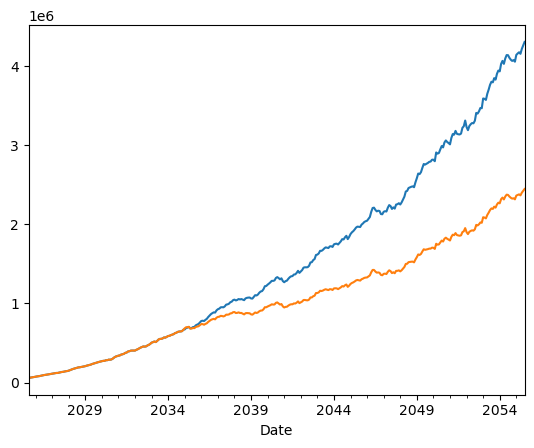

In [12]:
owner_table(years=30)['Stock_savings'].plot(label='')
owner_table(years=30, upgrade='2035-01-01')['Stock_savings'].plot()

<AxesSubplot: xlabel='Date'>

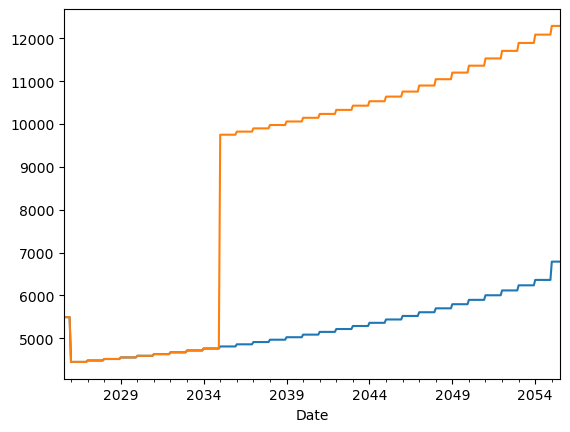

In [13]:
owner_table(years=30)['Post_tax_monthly'].plot(label='')
owner_table(years=30, upgrade='2035-01-01')['Post_tax_monthly'].plot()

In [14]:
def compare(scenario_1, scenario_2, returns_df, verbose=False, max_monthly=8000, max_down=300000):
    series_1 = owner_table(**scenario_1)
    series_2 = owner_table(**scenario_2)
    both = [series_1, series_2]
    if verbose:
        print(scenario_1['cost'])
        print("\tmonthly postax Year 1:", series_1['Post_tax_monthly'].iloc[0])
        print("\tmonthly interest+tax Year 1:", series_1['Unproductive_cost'].iloc[0])
        print("\tmonthly postax Year 2:", series_1['Post_tax_monthly'].loc['2026-01-01'])
        print("\tmonthly interest+tax Year 2:", series_1['Unproductive_cost'].loc['2026-01-01'])
        print("\tmonthly pretax", series_1['Pre_tax_monthly'].iloc[0])
        print(scenario_2['cost'])
        print("\tmonthly postax Year 1:", series_2['Post_tax_monthly'].iloc[0])
        print("\tmonthly interest+tax Year 1:", series_2['Unproductive_cost'].iloc[0])
        print("\tmonthly postax Year 2:", series_2['Post_tax_monthly'].loc['2026-01-01'])
        print("\tmonthly interest+tax Year 2:", series_2['Unproductive_cost'].loc['2026-01-01'])
        print("\tmonthly pretax", series_2['Pre_tax_monthly'].iloc[0])
    total_cost_1 = series_1['Purchase_cost'].iloc[0]
    total_cost_2 = series_2['Purchase_cost'].iloc[0]
    if verbose:
        print(scenario_1['cost'])
        print("\tupfront cost", total_cost_1)
        print(scenario_2['cost'])
        print("\tupfront cost", total_cost_2)
        print("\tDifference", (max(total_cost_1, total_cost_2) - min(total_cost_1, total_cost_2)))
    savings_1 = (max_down - total_cost_1) if (max_down - total_cost_1) > 0 else 0
    both[0]['Profit'] = both[0]['Profit'].add(apply_compounding(returns_df['Stock_Appreciation'],
                                                                savings_1,
                                                                np.zeros_like(returns_df['Stock_Appreciation']))
                                                                ).multiply(.85)
    savings_2 = (max_down - total_cost_2) if (max_down - total_cost_2) > 0 else 0
    both[1]['Profit'] = both[1]['Profit'].add(apply_compounding(returns_df['Stock_Appreciation'],
                                                                savings_2,
                                                                np.zeros_like(returns_df['Stock_Appreciation']))
                                                                ).multiply(.85)
    ##
    ##
    diff_0 = max_monthly - both[0]['Post_tax_monthly']
    diff_0[diff_0 < 0] = 0
    both[0]['Profit'] = both[0]['Profit'].add(apply_compounding(returns_df['Stock_Appreciation'],
                                                                0,
                                                                diff_0)
                                                                ).multiply(.85)
    diff_1 = max_monthly - both[1]['Post_tax_monthly']
    diff_1[diff_1 < 0] = 0
    both[1]['Profit'] = both[1]['Profit'].add(apply_compounding(returns_df['Stock_Appreciation'],
                                                                0,
                                                                diff_1)
                                                                ).multiply(.85)
    ##
    final_profit_1 = both[0]['Profit'].iloc[-1]
    final_profit_2 = both[1]['Profit'].iloc[-1]
    if verbose:
        print(scenario_1['cost'])
        print("\tFinal", final_profit_1)
        print(scenario_2['cost'])
        print("\tFinal", final_profit_2) 
    return both 

1340000
	monthly postax Year 1: 6950.8723161620455
	monthly interest+tax Year 1: 5714.168997239974
	monthly postax Year 2: 5701.624462398981
	monthly interest+tax Year 2: 4437.807911595084
	monthly pretax 7869.703318922072
980000
	monthly postax Year 1: 6078.498659083685
	monthly interest+tax Year 1: 4179.019117384459
	monthly postax Year 2: 5164.869631704728
	monthly interest+tax Year 2: 3245.561009972524
	monthly pretax 6750.4795416992265
1340000
	upfront cost 310880.0
980000
	upfront cost 427360.0
	Difference 116480.0
1340000
	Final 5231518.076826833
980000
	Final 5723933.312445618
	Total Reno: 0
	Reno excess monthly: 90.66666666666667
	Total Reno: 200000
	Reno excess monthly: 1061.3333333333333


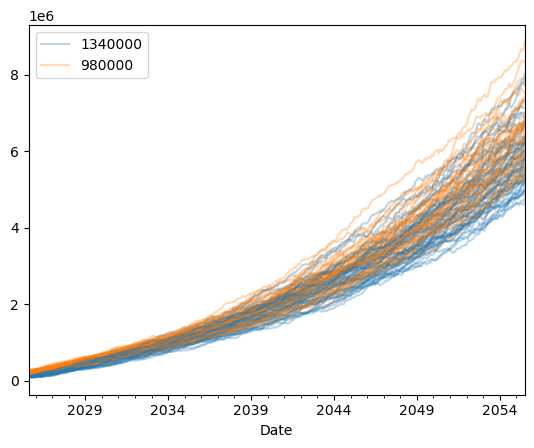

In [25]:
fig, ax = plt.subplots()
profits = {}
yr_10 = {}
yr_20 = {}
yr = {}
ir = 0.05625
for i in range(50):
    returns_df = simulate_returns()
    # No Reno
    scenario_1 = {'cost': 1_340_000, 'renovation': 0,
                  'mean_reno_return': .1,
                  # 'upgrade': '2033-01-01',
                  'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir,
                #   'upgrade_cost_today':1500000,
                #   'upgrade': '2033-01-01'
                  }
    scenario_2 = {'cost': 980000, 'renovation': 200_000,
                  'mean_reno_return': 1,
                  # 'upgrade': '2033-01-01',
                  'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir,
                #   'upgrade_cost_today':1500000,
                #   'upgrade': '2033-01-01'
                  }
    cornell = {'cost': 1_075_000, 'renovation': 15_000,
                  'mean_reno_return': 1,
                  # 'upgrade': '2033-01-01',
                  'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir,
                  'upgrade_cost_today':1500000,
                  'upgrade': '2033-01-01'
                  }
    fha = {'cost': 1_200_001, 'renovation': 70000,
                  'mean_reno_return': 1,
                  # 'upgrade': '2033-01-01',
                  'returns_df': returns_df, 'pct_down': .035, 'interest_rate':.07,
                #   'upgrade_cost_today':1500000,
                #   'upgrade': '2033-01-01'
                  }
    duplex = {'cost': 1_150_000, 'renovation': 80_000,
                  'hoa':-1241, 'condo': True,
                  'mean_reno_return': 1,
                  # 'upgrade': '2033-01-01',
                  'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir,
                #   'upgrade_cost_today':1500000,
                #   'upgrade': '2033-01-01'
                  }
    # Reno
    berkeley_way = {'cost': 1_050_000, 'renovation': 100_000,
                  'mean_reno_return': 2,
                  'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir}
    acroft = {'cost': 1_200_001, 'renovation': 120_000,
                  'mean_reno_return': 2,
                  # 'upgrade': '2033-01-01',
                  'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir}
    mcgee = {'cost': 1_250_001, 'renovation': 10_000,
              'mean_reno_return': 1,
              'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir}
    upgrader = {'cost': 1_100_000, 'renovation': 10_000,
              'mean_reno_return': .1,
              'upgrade': '2033-01-01',
              'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir}

    
    if i == 0:
        both = compare(scenario_1, scenario_2, returns_df, verbose=True)
        series_1 = owner_table(verbose=True, **scenario_1)
        series_2 = owner_table(verbose=True, **scenario_2)
        profits[str(scenario_1['cost'])] = []
        profits[str(scenario_2['cost'])] = []
        profits[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[-1])
        profits[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[-1])
        yr[str(scenario_1['cost'])] = []
        yr[str(scenario_2['cost'])] = []
        yr[str(scenario_1['cost'])].append(both[0]['Profit'])
        yr[str(scenario_2['cost'])].append(both[1]['Profit'])
        yr_10[str(scenario_1['cost'])] = []
        yr_10[str(scenario_2['cost'])] = []
        yr_10[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[10*12])
        yr_10[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[10*12])
        yr_20[str(scenario_1['cost'])] = []
        yr_20[str(scenario_2['cost'])] = []
        yr_20[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[20*12])
        yr_20[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[20*12])
        both[0]['Profit'].plot(ax=ax, label=str(scenario_1['cost']), color="tab:blue", alpha=.3)
        both[1]['Profit'].plot(ax=ax, label=str(scenario_2['cost']), color="tab:orange", alpha=.3)
    else:
       both = compare(scenario_1, scenario_2, returns_df)
       profits[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[-1])
       profits[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[-1])
       yr[str(scenario_1['cost'])].append(both[0]['Profit'])
       yr[str(scenario_2['cost'])].append(both[1]['Profit'])
       yr_10[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[10*12])
       yr_10[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[10*12])
       yr_20[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[20*12])
       yr_20[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[20*12])
       both[0]['Profit'].plot(ax=ax, label="_k", color="tab:blue", legend=False, alpha=.3)
       both[1]['Profit'].plot(ax=ax, label="_l", color="tab:orange", legend=False, alpha=.3) 
outcomes_df = pd.concat([
    pd.concat(yr[str(scenario_1['cost'])], axis=1).T.assign(variable=str(scenario_1['cost'])),
    pd.concat(yr[str(scenario_2['cost'])], axis=1).T.assign(variable=str(scenario_2['cost']))
])
outcomes_df.columns = both[0].index.astype(str).tolist() + outcomes_df.columns[len(both[0]):].tolist()
ax.legend();

In [16]:
pd.set_option('display.max_columns', None)


In [17]:
series_1.head(30)

,Period,Stock_Appreciation,Home_Appreciation,Purchase_cost,Principal_monthly,Interest_monthly,PropTax_monthly,Max_Monthly,PropTax_annual,Interest_annual,Total_deduction,Tax_Savings_annual,Tax_Savings_monthly,Pre_tax_monthly,Post_tax_monthly,Unproductive_cost,Balance_Remaining,Home_Value,Sale_fee,Capital_gain,Sale_tax,Profit,Stock_savings,Full_profit
Date,,,,,,,,,,,,,,,,,,,,,,,,
2025-08-01,1,-0.002012,0.006964,320880.0,1146.036652,5025.000000,1608.00,8300.00,8040.00,25071.027126,33111.027126,11025.972033,918.831003,7953.036652,7034.205649,5714.168997,1.070854e+06,1.350570e+06,94539.887149,10569.816417,0.0,142295.965920,926.157714,143222.123634
2025-09-01,2,0.008727,-0.001914,320880.0,1151.408699,5019.627953,1608.00,8300.00,8040.00,25071.027126,33111.027126,11025.972033,918.831003,7953.036652,7034.205649,5708.796950,1.069703e+06,1.347985e+06,94358.932116,7984.744509,0.0,141043.257745,1870.364213,142913.621958
2025-10-01,3,0.003663,0.009938,320880.0,1156.805927,5014.230725,1608.00,8300.00,8040.00,25071.027126,33111.027126,11025.972033,918.831003,7953.036652,7034.205649,5703.399722,1.068546e+06,1.361381e+06,95296.677046,21381.100655,0.0,154658.674888,2808.639855,157467.314743
2025-11-01,4,0.021156,0.018075,320880.0,1162.228455,5008.808197,1608.00,8300.00,8040.00,25071.027126,33111.027126,11025.972033,918.831003,7953.036652,7034.205649,5697.977194,1.067384e+06,1.385988e+06,97019.170715,45988.153070,0.0,178705.462089,3815.717833,182521.179922
2025-12-01,5,-0.000525,0.000867,320880.0,1167.676401,5003.360251,1608.00,8300.00,8040.00,25071.027126,33111.027126,11025.972033,918.831003,7953.036652,7034.205649,5692.529248,1.066216e+06,1.387190e+06,97103.295440,47189.934855,0.0,180990.795550,4741.251502,185732.047052
2026-01-01,6,0.011193,0.010076,320880.0,1173.149884,4997.886768,1640.16,8466.00,19681.92,59605.966722,79287.886722,26402.866278,2200.238857,7985.196652,5784.957796,4437.807912,1.065043e+06,1.401167e+06,98081.683902,61166.912891,0.0,195162.535008,6949.159119,202111.694126
2026-02-01,7,0.015031,0.009110,320880.0,1178.649024,4992.387628,1640.16,8466.00,19681.92,59605.966722,79287.886722,26402.866278,2200.238857,7985.196652,5784.957796,4432.308772,1.063864e+06,1.413932e+06,98975.241216,73932.017372,0.0,208212.731199,9216.630835,217429.362034
2026-03-01,8,-0.012231,0.000464,320880.0,1184.173942,4986.862711,1640.16,8466.00,19681.92,59605.966722,79287.886722,26402.866278,2200.238857,7985.196652,5784.957796,4426.783854,1.062680e+06,1.414588e+06,99021.167219,74588.103128,0.0,210007.064894,11208.822137,221215.887031
2026-04-01,9,0.012527,0.020477,320880.0,1189.724757,4981.311895,1640.16,8466.00,19681.92,59605.966722,79287.886722,26402.866278,2200.238857,7985.196652,5784.957796,4421.233039,1.061490e+06,1.443555e+06,101048.866222,103555.231748,0.0,238136.219267,13506.910915,251643.130183


In [18]:
selection = '2032-01-01'
df_select = outcomes_df[[selection, 'variable']]
df_select = df_select.rename(columns={selection: 'value'})
mod = sm.regression.quantile_regression.QuantReg.from_formula("value ~ I(variable)", data=df_select).fit(q=0.5)
print("Q-Reg:")
print(mod.summary().tables[-1])
mod = sm.OLS.from_formula("value ~ I(variable)", data=df_select).fit()
print("Linear-Reg:")
print(mod.summary().tables[1])

Q-Reg:
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              7.271e+05   1.95e+04     37.281      0.000    6.88e+05    7.66e+05
I(variable)[T.980000]  1.011e+05   2.76e+04      3.664      0.000    4.63e+04    1.56e+05
Linear-Reg:
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              7.419e+05   1.31e+04     56.719      0.000    7.16e+05    7.68e+05
I(variable)[T.980000]  8.896e+04   1.85e+04      4.809      0.000    5.22e+04    1.26e+05


In [19]:
df_select.groupby('variable')['value'].agg(['mean', 'median'])

,mean,median
variable,,
1340000,741901.065653,726782.907970
980000,830857.570777,828021.175253


#### 10yr

In [20]:
mod = sm.regression.quantile_regression.QuantReg.from_formula("value ~ I(variable)", data =pd.DataFrame(yr_10).melt()).fit(q=0.5)
mod.summary().tables[-1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.183e+06,2.94e+04,40.242,0.000,1.12e+06,1.24e+06
I(variable)[T.980000],8.62e+04,4.16e+04,2.073,0.041,3693.225,1.69e+05


In [21]:
mod.params.iloc[-1]/10/12

718.2997230456211

#### 20 yr

In [22]:
mod = sm.regression.quantile_regression.QuantReg.from_formula("value ~ I(variable)", data =pd.DataFrame(yr_20).melt()).fit(q=0.5)
mod.summary().tables[-1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.009e+06,9.29e+04,32.387,0.000,2.82e+06,3.19e+06
I(variable)[T.980000],2.264e+05,1.31e+05,1.723,0.088,-3.44e+04,4.87e+05


In [23]:
mod.params.iloc[-1]/20/12

943.2624762866258

#### 30 yr

In [24]:
mod = sm.regression.quantile_regression.QuantReg.from_formula("value ~ I(variable)", data =pd.DataFrame(profits).melt()).fit(q=0.5)
mod.summary().tables[-1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.69e+06,1.92e+05,29.704,0.000,5.31e+06,6.07e+06
I(variable)[T.980000],7.835e+05,2.71e+05,2.893,0.005,2.46e+05,1.32e+06
